In [16]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Custom modules
from approximators import MLP, QValueApproximator
from states import EnvironmentState
from agents import LearningAgent
from data import DataGenerator

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [17]:
n_levels = 10
horizon = 120
action_size = 10
n_episodes = 10

data = DataGenerator.generator("../data/SAMPO.parquet", levels=n_levels).head(30000)

means = data[['Mid Price Movement', 'Market Spread', 'Book Imbalance', 'Signed Volume', 'Volatility', 'RSI']].mean()
means = np.concatenate([means.values, [0, 2.5, 2.5, 4.5]])

stds = data[['Mid Price Movement', 'Market Spread', 'Book Imbalance', 'Signed Volume', 'Volatility', 'RSI']].std()
stds = np.concatenate([stds.values, [1e4/3, 1.9, 1.9, 3]])

# Combine the two vectors in a matirx
std_values = np.vstack((means, stds)).T.astype(np.float32)

windows = []
for i in range(n_episodes):
    windows.append(data.iloc[i*(horizon+1):(i+1)*(horizon+1)])

In [ ]:
model = MLP(10, 1, [64, 128, 64], torch.nn.ReLU, 0.05, device).to(device)
q_approximator = QValueApproximator(model, 1e-4, std_values)

In [19]:
agent = LearningAgent(
    action_size=action_size,
    q_value_approximator=q_approximator,
    epsilon=0.5,
    epsilon_decay=0.97,
    min_epsilon=0.01,
    gamma=0.99,
)

env = EnvironmentState(data, n_levels, horizon)

In [20]:
rewards_train, losses_train, bankrolls_train = [], [], []

for episode in tqdm(range(20*n_episodes)):
    episode = episode % n_episodes
    env.data = windows[episode]
    rewards, losses, bankrolls = agent.train(env, 1)
    rewards_train.extend(rewards)
    losses_train.extend(losses)
    bankrolls_train.extend(bankrolls)

rewards_train = pd.Series(rewards_train)
losses_train = pd.Series(losses_train)
bankrolls_train = pd.Series(bankrolls_train)

  0%|          | 0/200 [00:00<?, ?it/s]

<Axes: >

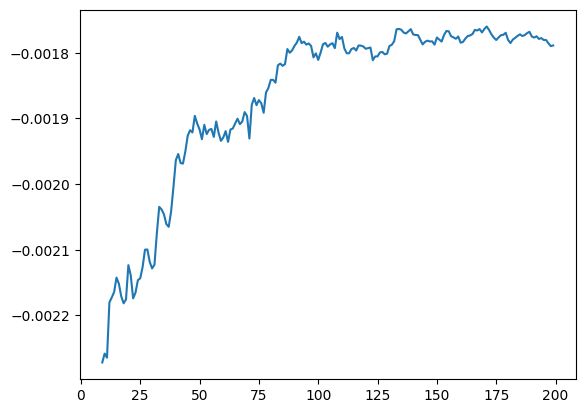

In [24]:
rewards_train.rolling(n_episodes).mean().plot()

<Axes: >

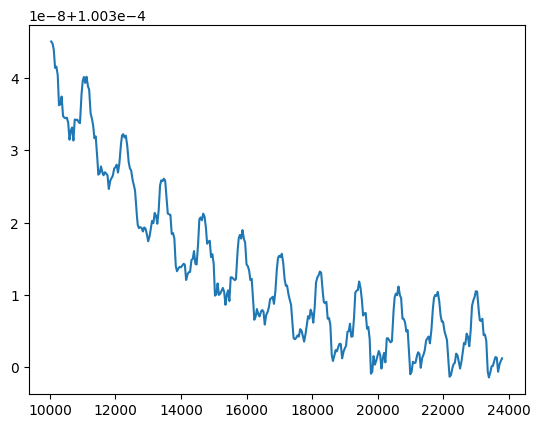

In [25]:
losses_train.rolling(10000).mean().plot()

<Axes: >

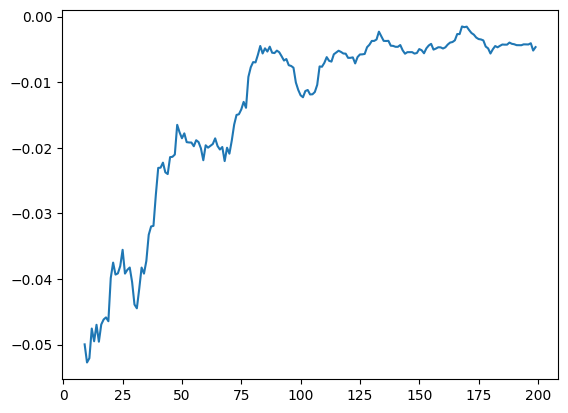

In [26]:
bankrolls_train.rolling(n_episodes).mean().plot()